# Storm-time Superposed Analysis of Solar, Solar Wind and Atmospheric Variables

Superposed Epoch Anlysis for the satellite drag variables during storms. 

Initial data can be read in through the 1 hour omni data. The 1 hour is probably sufficient as we are mostly interetsed in what the solar wind variables are doing through storms as compared to the atmospheric density. 

Notes:
- Solar wind variables are daily variables and so we might have to a typical superposed epoch analysis if the storm phases are short as opposed to a time-normalized analysis.
- Solar Variables used in models
    - F10.7, S10, M10, Y10, F30, F81
- Geomagnetic Variables used in models
    - Kp, ap, Dst, n_sw, v_sw, IMF
- DTM2020 has to models, an operational and research model
    - Operational uses lower cadence F10.7 and KP indices as inputs
    - Research model used higher cadence F30 and Hpo indices as inputs

Data that needs to be retrieved. 
- S10, the S10.7 index is an activity indicator of the integrated 26–34 nm solar irradiance measured by the Solar Extreme-ultraviolet Monitor (SEM) instrument on the NASA/ESA Solar and Heliospheric Observatory (SOHO) satellite
- M10, the M10.7 index is derived from the Mg II core-to-wing ratio that originated from the NOAA series operational satellites, e.g., NOAA-16,-17,-18, which host the Solar Backscatter Ultraviolet (SBUV) spectrometer.
- Y10, a composite solar index of the Xb10 index, Lyman-α emission and 81-day cantered smoothed F10.7. Xb10 index and is used to represent the daily energy that is deposited into the mesosphere and lower thermosphere.
- F30, the F30 is the Solar Flux measured by the Nobeyama Radio Observatory, which performs daily measurements of the 30 cm radio flux on an operational 7/365 basis.
- F81
- Hpo 

[JB2008 indicies](https://sol.spacenvironment.net/jb2008/indices.html)
ESA Space Weather Service Network, [Space Surveillance and Tracking (Archive of geomagnetic and solar indices for drag calculation)](https://swe.ssa.esa.int/sst_arv)


In [1]:
#plot matplotlib figures in the notebook
%matplotlib inline

#print all output in a cell 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sea_norm import sean

In [3]:
local_dir = 'D:\\data\\OMNI'

def load_omni(res: str = '1h',
         sdate='2010-01-01',
         nd: int = 1,
         edate=None,
         gz=True,
         dl=True,
         drop_flag=True,
         force=False):
    

    if res == '1h':
        d_dir = 'YEARLY_1HOUR'
        freq = 'Y'
        cols = {'Year':None, 'DOY':None, 'HR':None,
                'BRN':9999, 'IMFid':99, 'SWid':99,
                'IMFavg':999, 'SWavg':999, 'Bavg':999.9, 'B':999.9,
                'BLatAlpha':999.9, 'BLonAlpha':999.9, 
                'BxGSEGSM':999.9, 'ByGSE':999.9, 'BzGSE':999.9, 
                'ByGSM':999.9, 'BzGSM':999.9, 'sigB':999.9, 'sigBv':999.9,
                'sigBx':999.9, 'sigBy':999.9, 'sigBz':999.9, 'Tp':9999999.,
                'Prho':999.9, 'Vsw':9999., 'VLonAlpha':999.9, 'VLatAlpha':999.9, 
                'APratio':9.999, 'dynP':99.99, 'sigT':9999999., 'sigPrho':999.9,
                'sigVsw':9999., 'sigVLon':999.9, 'sigVLat':999.9,
                'sigAPratio':9.999, 'Esw':999.99, 'Beta':999.99, 'AlfvenMach':999.9,
                'Kp':99, 'nSunSpot':999, 'Dst':99999, 'AE':9999, 
                'PF1':999999.99, 'PF2':99999.99, 'PF3':99999.99, 'PF4':99999.99,
                'PF5':99999.99, 'PF6':99999.99, 'PFlag':0, 'AP':999, 'F10':999.9, 
                'PC':999.9, 'AL':99999, 'AU':99999, 'MagMach':99.9}
        desc = '''Omni2 data from https://spdf.gsfc.nasa.gov/pub/data/omni/low_res_omni/
        Description and units at https://spdf.gsfc.nasa.gov/pub/data/omni/low_res_omni/omni2.text
                '''
    elif res == '5m':
        d_dir = ''
        freq = 'Y'
    elif res =='1m':
        d_dir = ''
        freq = 'M'
    else:
        d_dir = 'YEARLY_1HOUR'
        freq = 'Y'

    if edate is not None:
        d_ser = pd.date_range(start=sdate, end=edate, freq=freq)
    else:
        d_ser = pd.date_range(
            start=sdate, periods=nd, freq=freq)

    #fn = glob.glob(os.path.join(local_dir,d_dir,'[2014-2016]'))

    # create file names
    fn = [os.path.join(local_dir,d_dir,f'omni2_{x.year}.dat') for x in d_ser]
    # check that the files exist
    fe = [ os.path.exists(w) for w in fn]

    f_df = pd.DataFrame({'fname':fn,'fexists':fe})

    # add download if files doesn't exist here 
    # this is when this get's transferred to it's own function

    fl = f_df.loc[f_df['fexists'] == True,'fname']
    
    o_dat = pd.concat((pd.read_csv(f,delim_whitespace=True,engine='python', 
                        header=None, on_bad_lines='skip', names=list(cols.keys()),
                        parse_dates=[[0,1,2]]) for f in fl), 
                        ignore_index=True)
    o_dat.rename(columns={'Year_DOY_HR':'DateTime'}, inplace=True)
    o_dat['DateTime'] = pd.to_datetime(o_dat['DateTime'],format='%Y %j %H')

    # remove bad data and replace with NaN
    for k, kval in cols.items():
        if kval is None:
             continue
        o_dat.loc[o_dat[k] >= kval, k] = np.nan

    return o_dat, desc

In [3]:
def load_solar_indices(sdate='2010-01-01', 
                       nd: int = 1,
                       edate=None):
    
    desc = '''Solar Wind indices used in the JB2008 model.
    Data can be downloaded at https://sol.spacenvironment.net/jb2008/indices.html'''
    f='D:\\data\\SOLFSMY.txt'

    cols = ['YYYY','DDD','JulianDay', 'F10', 'F81',
            'S10','S81c','M10','M81c','Y10', 'Y81c',
            'Ssrc']

    sdate = pd.to_datetime(sdate)
    if edate is None:
        edate = sdate+pd.DateOffset(days=nd)
    else:
        edate = pd.to_datetime(edate)
    
    if edate < sdate:
        print('End date is smaller then start date')
        print('setting end date to start date + 1 day')
        edate = sdate+pd.DateOffset(days=nd)

    # lines to skip to get to the start date
    skip_l = np.int32((sdate-pd.to_datetime('1997-01-01')).total_seconds()/86400)
    read_l = np.int32((edate-sdate).total_seconds()/86400)

    s_dat = pd.read_csv(f,delim_whitespace=True,engine='python', 
                        header=None, on_bad_lines='skip', names=list(cols),
                        parse_dates=[[0,1]], 
                        skiprows=skip_l+4, nrows=read_l)
    
    s_dat.rename(columns={'YYYY_DDD':'DateTime'}, inplace=True)
    s_dat['DateTime'] = pd.to_datetime(s_dat['DateTime'],format='%Y %j')

    return s_dat, desc
    


In [4]:
# get storm times
# read in storm start and end times

storm_txt = 'D:\\GitHub\\SatDrag\\data\\storms_drag_epochs_no_overlap.txt'
storm_time = pd.read_csv(storm_txt, header=None, skiprows=1, 
                     delim_whitespace=1, names = ['t_st','t_dst','t_en'], parse_dates=[0, 1, 2],
                     infer_datetime_format=True)

In [5]:
# Read in the satellite drag database
fn = 'D:\\data\\VL_sdrag\\satdrag_database_zlib.hdf5'
columns = ['Datetime','400kmDensity', 'DensityHeight', 'DenUncertainty','storm', 'storm phase']
sd_d = pd.read_hdf(fn, columns=columns)

sd_d['Datetime'].min()
sd_d['Datetime'].max()

Timestamp('2002-08-01 00:01:00')

Timestamp('2012-07-01 00:00:00')

In [17]:
sol_d, _ = load_solar_indices(sdate=sd_d['Datetime'].min(), edate=sd_d['Datetime'].max()+pd.DateOffset(days=2))
omni_d, _ = load_omni(sdate=sd_d['Datetime'].min(), edate=sd_d['Datetime'].max()+pd.DateOffset(hours=2))

print(sol_d.columns)
print(omni_d.columns)


Index(['DateTime', 'JulianDay', 'F10', 'F81', 'S10', 'S81c', 'M10', 'M81c',
       'Y10', 'Y81c', 'Ssrc'],
      dtype='object')
Index(['DateTime', 'BRN', 'IMFid', 'SWid', 'IMFavg', 'SWavg', 'Bavg', 'B',
       'BLatAlpha', 'BLonAlpha', 'BxGSEGSM', 'ByGSE', 'BzGSE', 'ByGSM',
       'BzGSM', 'sigB', 'sigBv', 'sigBx', 'sigBy', 'sigBz', 'Tp', 'Prho',
       'Vsw', 'VLonAlpha', 'VLatAlpha', 'APratio', 'dynP', 'sigT', 'sigPrho',
       'sigVsw', 'sigVLon', 'sigVLat', 'sigAPratio', 'Esw', 'Beta',
       'AlfvenMach', 'Kp', 'nSunSpot', 'Dst', 'AE', 'PF1', 'PF2', 'PF3', 'PF4',
       'PF5', 'PF6', 'PFlag', 'AP', 'F10', 'PC', 'AL', 'AU', 'MagMach'],
      dtype='object')


In [19]:
omni_d = omni_d.set_index('DateTime')
sol_d = sol_d.set_index('DateTime')


100%|██████████| 345/345 [00:02<00:00, 158.46it/s]


There is no data for event 318
There is no data for event 319
There is no data for event 320
There is no data for event 321
There is no data for event 322
There is no data for event 323
There is no data for event 324
There is no data for event 325
There is no data for event 326
There is no data for event 327
There is no data for event 328
There is no data for event 329
There is no data for event 330
There is no data for event 331
There is no data for event 332
There is no data for event 333
There is no data for event 334
There is no data for event 335
There is no data for event 336
There is no data for event 337
There is no data for event 338
There is no data for event 339
There is no data for event 340
There is no data for event 341
There is no data for event 342
There is no data for event 343
There is no data for event 344


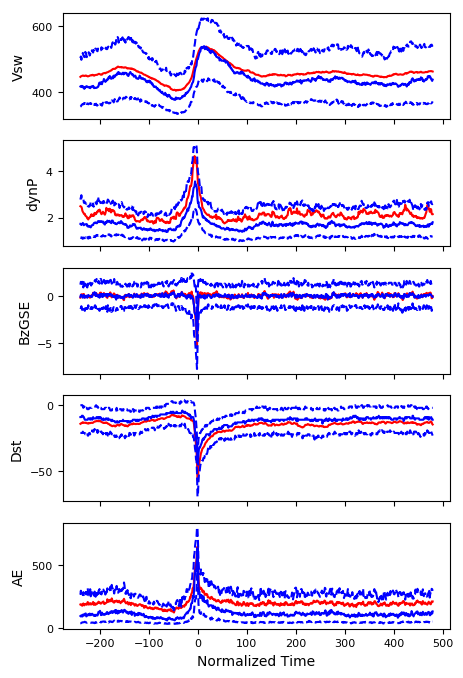

In [36]:
# set the columns to run the analysis on
sea_cols = ['Vsw','dynP','BzGSE','Dst','AE']

# specify the number of bins in phase 1 and phase 2 as [nbins1, nbins2]
bins=[24*10., 24*20.-1]

starts = storm_time.t_st
epochs = storm_time.t_dst
ends = storm_time.t_en

epochs = storm_time.t_dst

starts = pd.Series([x-pd.DateOffset(days=10) for x in epochs])
ends = pd.Series([x+pd.DateOffset(days=20) for x in epochs])
events=[starts, epochs, ends]

# perform the noramlized superposed epoch analysis
SEAarray, meta = sean(omni_d, events, bins, cols=sea_cols)

# get the columsn that the SEA was performed
# on from the returned metadata
cols = meta['sea_cols']                           

# plot the superposed epoch analysis for each variable
# plot the mean, median, upper and lower quartiles
# ignore the cnts column

fig, axes = plt.subplots(nrows=len(cols), sharex=True, 
                         squeeze=True,figsize=(5,8))

# loop over columns that were analyzed
for c, ax in zip(cols, axes):
    # for each column identify the column titles which
    # have 'c' in the title and those that don't have
    # 'cnt' in the title 
    # e.g. for AE columns 
    # AE_mean, AE_median, AE_lowq, AE_upq, AE_cnt
    # fine columns AE_mean, AE_median, AE_lowq, AE_upq     
    mask = SEAarray.columns.str.startswith(c) & \
        ~SEAarray.columns.str.endswith('cnt')
        
    # plot the SEA data
    SEAarray.loc[:,mask].plot(ax=ax, style=['r-','b-','b--','b--'], 
                              xlabel='Normalized Time',
                              ylabel=c.replace('_',' '), 
                              legend=False, fontsize=8)

plt.show()

In [30]:
sea_cols = ['F10', 'S10', 'M10', 'Y10']

# specify the number of bins in phase 1 and phase 2 as [nbins1, nbins2]
bins=[10, 20]

epochs = storm_time.t_dst

starts = pd.Series([x-pd.DateOffset(days=10) for x in epochs])
ends = pd.Series([x+pd.DateOffset(days=20) for x in epochs])

events=[starts, epochs, ends]

 11%|█▏        | 39/345 [00:00<00:00, 372.46it/s]

There is no data for event 0
There is no data for event 1
There is no data for event 2
There is no data for event 3
There is no data for event 4
There is no data for event 5
There is no data for event 6
There is no data for event 7
There is no data for event 8
There is no data for event 9
There is no data for event 10
There is no data for event 11
There is no data for event 12
There is no data for event 13
There is no data for event 14
There is no data for event 15
There is no data for event 16
There is no data for event 17
There is no data for event 18
There is no data for event 19
There is no data for event 20
There is no data for event 21
There is no data for event 22
There is no data for event 23
There is no data for event 24
There is no data for event 25
There is no data for event 26
There is no data for event 27
There is no data for event 28
There is no data for event 29


100%|██████████| 345/345 [00:01<00:00, 213.14it/s]


There is no data for event 334
There is no data for event 335
There is no data for event 336
There is no data for event 337
There is no data for event 338
There is no data for event 339
There is no data for event 340
There is no data for event 341
There is no data for event 342
There is no data for event 343
There is no data for event 344


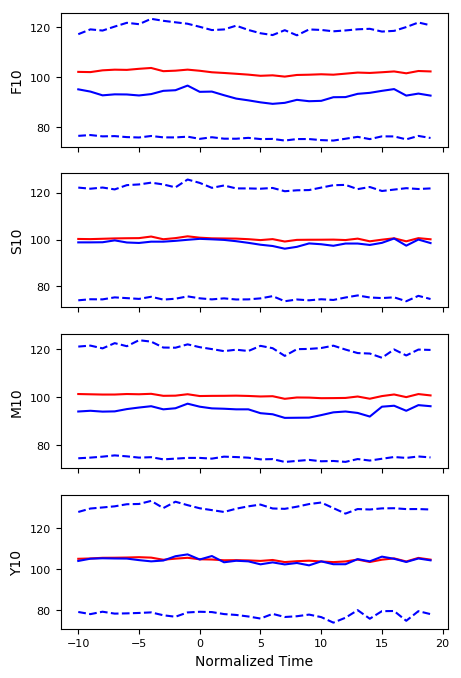

In [31]:
# set the columns to run the analysis on


# perform the noramlized superposed epoch analysis
SEAarray, meta = sean(sol_d, events, bins, cols=sea_cols)

# get the columsn that the SEA was performed
# on from the returned metadata
cols = meta['sea_cols']                           

# plot the superposed epoch analysis for each variable
# plot the mean, median, upper and lower quartiles
# ignore the cnts column

fig, axes = plt.subplots(nrows=len(cols), sharex=True, 
                         squeeze=True,figsize=(5,8))

# loop over columns that were analyzed
for c, ax in zip(cols, axes):
    # for each column identify the column titles which
    # have 'c' in the title and those that don't have
    # 'cnt' in the title 
    # e.g. for AE columns 
    # AE_mean, AE_median, AE_lowq, AE_upq, AE_cnt
    # fine columns AE_mean, AE_median, AE_lowq, AE_upq     
    mask = SEAarray.columns.str.startswith(c) & \
        ~SEAarray.columns.str.endswith('cnt')
        
    # plot the SEA data
    SEAarray.loc[:,mask].plot(ax=ax, style=['r-','b-','b--','b--'], 
                              xlabel='Normalized Time',
                              ylabel=c.replace('_',' '), 
                              legend=False, fontsize=8)

plt.show()